In [32]:
import jax
import jax.numpy as jnp
import numpy as np
import equinox as eqx
from diffrax import diffeqsolve, ODETerm, Tsit5, SaveAt

# --- Define RHS network architecture ---
class RHS(eqx.Module):
    mlp: eqx.nn.MLP
    def __init__(self, key=None):
        dummy_key = jax.random.PRNGKey(0) if key is None else key
        self.mlp = eqx.nn.MLP(in_size=264, out_size=262, width_size=512, depth=4, key=dummy_key)

    def __call__(self, P, H, z):
        x = jnp.concatenate([P, H, jnp.atleast_1d(z)])
        return self.mlp(x)

ys_list = []
for i in range(10):
    # --- Load trained model ---
    model_path = "/srv/scratch2/taylor.4264/odd_emu/models/learned_model_low_z_log_%s.eqx" %i
    model = RHS()
    model_params = eqx.tree_deserialise_leaves(model_path, model)
    model = eqx.combine(model_params, model)

    # --- Load H(z) and P(z) initial condition ---
    Hz_all = np.load("/srv/scratch2/taylor.4264/odd_emu/batched_low_z/Hz_all.npy")     # (30000, 100)
    pk_all = np.load("/srv/scratch2/taylor.4264/odd_emu/batched_low_z/pk_nl_all.npy")  # (30000, 100, 262)
    z_grid = np.load("/srv/scratch2/taylor.4264/odd_emu/batched_low_z/z.npy")          # (100,)

    # Use first sample as reference
    Hz_ref = Hz_all[0][::-1]        # reverse for decreasing z
    z_grid_rev = z_grid[::-1]       # high → low redshift

    # Interpolated function H(z), valid for decreasing z
    def H_func(z):
        return jnp.interp(z, z_grid_rev, Hz_ref)

    # Initial condition at z_max
    P0 = pk_all[28, -1]              
    y0 = jnp.log(jnp.array(P0))  # ✅ integrate log(P)


    # Time range: high z to low z
    z0 = float(z_grid[-1])          # e.g., z = 5
    z1 = float(z_grid[0])           # e.g., z = 0
    ts = jnp.linspace(z0, z1, 100)  # forward in time

    # --- Define RHS for ODE
    def rhs(z, P, args):
        model, H_fn = args
        H_z = jnp.atleast_1d(H_fn(z))
        return model(P, H_z, z)

    # --- Solve ODE
    term = ODETerm(rhs)
    solver = Tsit5()
    saveat = SaveAt(ts=ts)

    sol = diffeqsolve(
        term,
        solver,
        t0=z0,
        t1=z1,
        dt0=-1e-2,  # negative because z is decreasing
        y0=y0,
        args=(model, H_func),
        saveat=saveat
    )

    print("Integrated P(z) shape (forward in time):", sol.ys.shape)
    Pz = jnp.exp(sol.ys)
    ys_list.append(Pz)



Integrated P(z) shape (forward in time): (100, 262)
Integrated P(z) shape (forward in time): (100, 262)
Integrated P(z) shape (forward in time): (100, 262)
Integrated P(z) shape (forward in time): (100, 262)
Integrated P(z) shape (forward in time): (100, 262)
Integrated P(z) shape (forward in time): (100, 262)
Integrated P(z) shape (forward in time): (100, 262)
Integrated P(z) shape (forward in time): (100, 262)
Integrated P(z) shape (forward in time): (100, 262)
Integrated P(z) shape (forward in time): (100, 262)


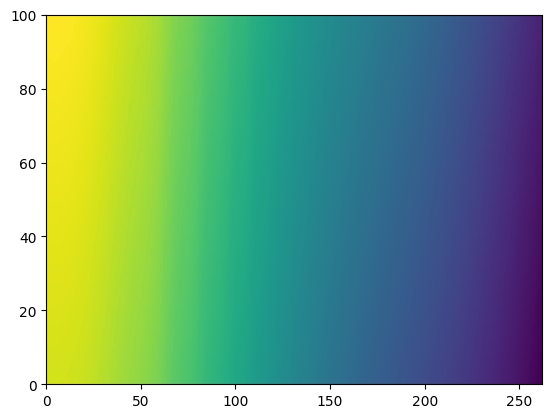

In [33]:
from matplotlib import pyplot as plt
plt.pcolormesh(sol.ys)

In [34]:
parent_dir = "/srv/scratch2/taylor.4264/odd_emu/batched"
k = np.load(parent_dir + "/k.npy")  # (262,)'')

Text(0.5, 1.0, 'z=0.5')

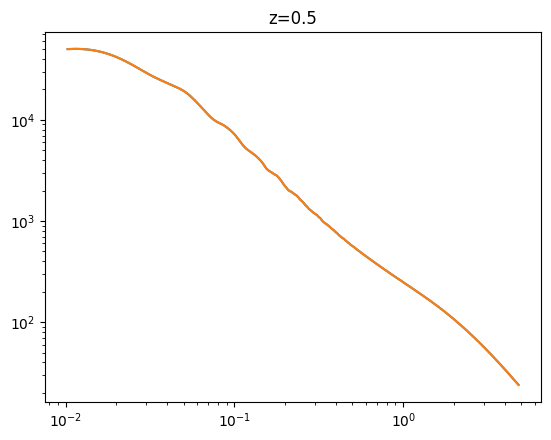

In [38]:
plt.plot(k, Pz[0])
plt.plot(k, pk_all[:,::-1][28, 0])
plt.xscale('log')
plt.yscale('log')
plt.title('z=0.5')



Text(0.5, 1.0, 'z=0')

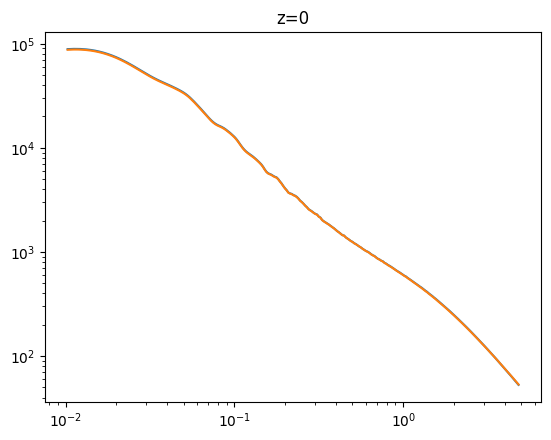

In [39]:
plt.plot(k, Pz[99])
plt.plot(k, pk_all[:,::-1][28, 99])
plt.xscale('log')
plt.yscale('log')
plt.title('z=0')

In [40]:
combined = np.average(np.array(ys_list), axis = 0)
print (np.shape(combined))

(100, 262)


Text(0.5, 1.0, 'z=0')

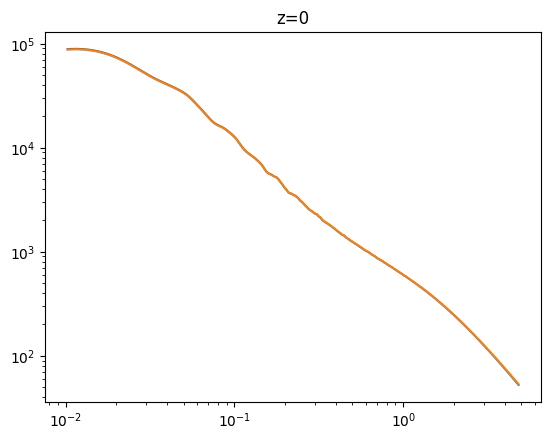

In [41]:
plt.plot(k, combined[99])
plt.plot(k, pk_all[:,::-1][28, 99])
plt.xscale('log')
plt.yscale('log')
plt.title('z=0')

[8.83016094e+04 8.85408750e+04 8.86944375e+04 8.87982344e+04
 8.87984453e+04 8.87533906e+04 8.86182969e+04 8.83912266e+04
 8.80783984e+04 8.77077891e+04 8.72642734e+04 8.67078281e+04
 8.60712109e+04 8.53675156e+04 8.45526719e+04 8.36713281e+04
 8.27292266e+04 8.16650469e+04 8.05433359e+04 7.93391641e+04
 7.80665391e+04 7.67342344e+04 7.53300312e+04 7.38719375e+04
 7.23637344e+04 7.08091406e+04 6.92244219e+04 6.76273516e+04
 6.59730469e+04 6.43217578e+04 6.26757305e+04 6.10185703e+04
 5.93896953e+04 5.77622383e+04 5.61811016e+04 5.46263242e+04
 5.31204141e+04 5.16509922e+04 5.02616133e+04 4.89396797e+04
 4.76958672e+04 4.65124609e+04 4.54259727e+04 4.44036602e+04
 4.34288125e+04 4.25261484e+04 4.16416797e+04 4.07930234e+04
 3.99446016e+04 3.90928242e+04 3.82502812e+04 3.74029766e+04
 3.65450195e+04 3.56621406e+04 3.47434688e+04 3.37714141e+04
 3.26964219e+04 3.15367500e+04 3.02674219e+04 2.89436973e+04
 2.76011680e+04 2.62738242e+04 2.49928164e+04 2.37530293e+04
 2.25453711e+04 2.137555

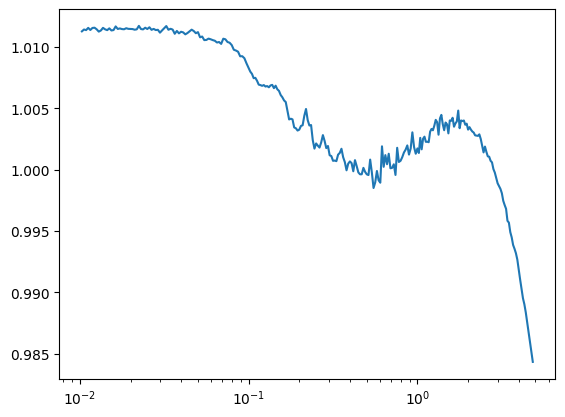

In [42]:
plt.plot(k, combined[99] / pk_all[:,::-1][28, 99])
plt.xscale('log')

print(combined[99])

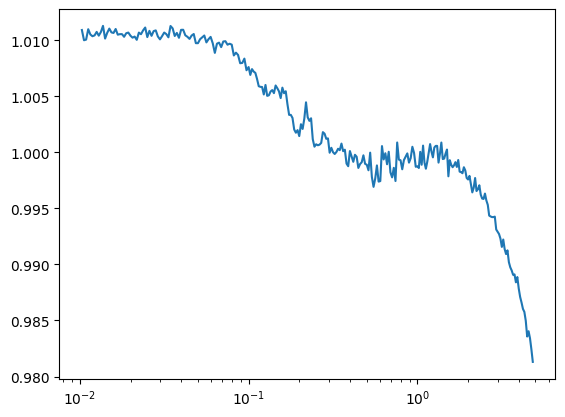

In [43]:
plt.plot(k, ys_list[0][99] / pk_all[:,::-1][28, 99])
plt.xscale('log')

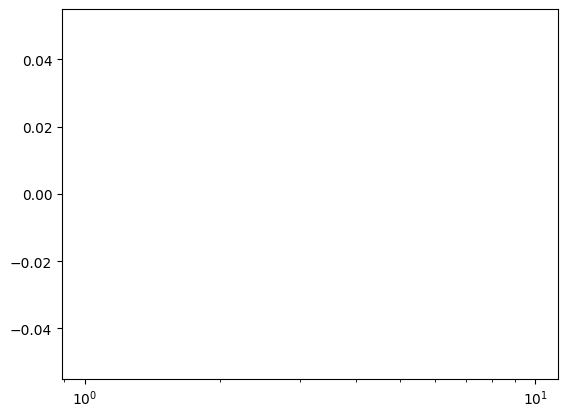

In [ ]:
plt.plot(k, sol.ys[99] / pk_all[:,::-1][28, 99])
plt.xscale('log')


Integrated P(z) shape (forward in time): (100, 262)
Integrated P(z) shape (forward in time): (100, 262)
Integrated P(z) shape (forward in time): (100, 262)
Integrated P(z) shape (forward in time): (100, 262)
Integrated P(z) shape (forward in time): (100, 262)
Integrated P(z) shape (forward in time): (100, 262)
Integrated P(z) shape (forward in time): (100, 262)
Integrated P(z) shape (forward in time): (100, 262)
Integrated P(z) shape (forward in time): (100, 262)
Integrated P(z) shape (forward in time): (100, 262)


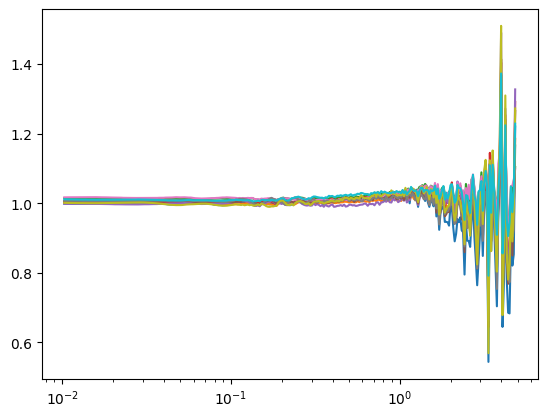

In [ ]:
import jax
import jax.numpy as jnp
import numpy as np
import equinox as eqx
from diffrax import diffeqsolve, ODETerm, Tsit5, SaveAt

for ii in range(10):
    # --- Define RHS network architecture ---
    class RHS(eqx.Module):
        mlp: eqx.nn.MLP
        def __init__(self, key=None):
            dummy_key = jax.random.PRNGKey(0) if key is None else key
            self.mlp = eqx.nn.MLP(in_size=264, out_size=262, width_size=512, depth=4, key=dummy_key)

        def __call__(self, P, H, z):
            x = jnp.concatenate([P, H, jnp.atleast_1d(z)])
            return self.mlp(x)

    # --- Load trained model ---
    model_path = "/srv/scratch2/taylor.4264/odd_emu/models/learned_model_low_z.eqx"
    model = RHS()
    model_params = eqx.tree_deserialise_leaves(model_path, model)
    model = eqx.combine(model_params, model)

    # --- Load H(z) and P(z) initial condition ---
    Hz_all = np.load("/srv/scratch2/taylor.4264/odd_emu/batched_low_z/Hz_all.npy")     # (30000, 100)
    pk_all = np.load("/srv/scratch2/taylor.4264/odd_emu/batched_low_z/pk_nl_all.npy")  # (30000, 100, 262)
    z_grid = np.load("/srv/scratch2/taylor.4264/odd_emu/batched_low_z/z.npy")          # (100,)

    # Use first sample as reference
    Hz_ref = Hz_all[0][::-1]        # reverse for decreasing z
    z_grid_rev = z_grid[::-1]       # high → low redshift

    # Interpolated function H(z), valid for decreasing z
    def H_func(z):
        return jnp.interp(z, z_grid_rev, Hz_ref)

    # Initial condition at z_max
    P0 = pk_all[ii, -1]              # corresponds to highest redshift z = z_grid[-1]

    # Time range: high z to low z
    z0 = float(z_grid[-1])          # e.g., z = 5
    z1 = float(z_grid[0])           # e.g., z = 0
    ts = jnp.linspace(z0, z1, 100)  # forward in time

    # --- Define RHS for ODE
    def rhs(z, P, args):
        model, H_fn = args
        H_z = jnp.atleast_1d(H_fn(z))
        return model(P, H_z, z)

    # --- Solve ODE
    term = ODETerm(rhs)
    solver = Tsit5()
    saveat = SaveAt(ts=ts)

    sol = diffeqsolve(
        term,
        solver,
        t0=z0,
        t1=z1,
        dt0=-1e-2,  # negative because z is decreasing
        y0 = jnp.log(jnp.array(P0)),
        args=(model, H_func),
        saveat=saveat
    )

    print("Integrated P(z) shape (forward in time):", sol.ys.shape)
    plt.plot(k, sol.ys[99] / pk_all[:,::-1][ii, 99])
    plt.xscale('log')


Integrated P(z) shape (forward in time): (100, 262)
Integrated P(z) shape (forward in time): (100, 262)
Integrated P(z) shape (forward in time): (100, 262)
Integrated P(z) shape (forward in time): (100, 262)
Integrated P(z) shape (forward in time): (100, 262)
Integrated P(z) shape (forward in time): (100, 262)
Integrated P(z) shape (forward in time): (100, 262)
Integrated P(z) shape (forward in time): (100, 262)
Integrated P(z) shape (forward in time): (100, 262)
Integrated P(z) shape (forward in time): (100, 262)


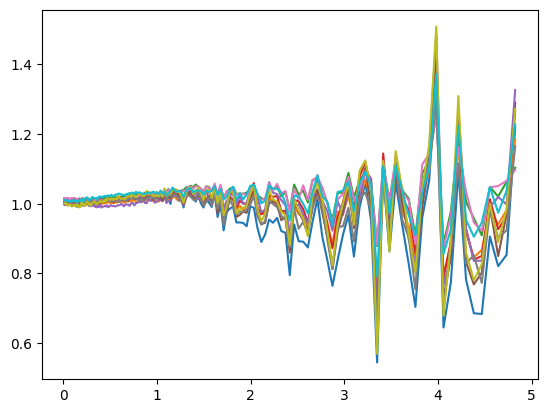

In [70]:
import jax
import jax.numpy as jnp
import numpy as np
import equinox as eqx
from diffrax import diffeqsolve, ODETerm, Tsit5, SaveAt

for ii in range(10):
    # --- Define RHS network architecture ---
    class RHS(eqx.Module):
        mlp: eqx.nn.MLP
        def __init__(self, key=None):
            dummy_key = jax.random.PRNGKey(0) if key is None else key
            self.mlp = eqx.nn.MLP(in_size=264, out_size=262, width_size=512, depth=4, key=dummy_key)

        def __call__(self, P, H, z):
            x = jnp.concatenate([P, H, jnp.atleast_1d(z)])
            return self.mlp(x)

    # --- Load trained model ---
    model_path = "/srv/scratch2/taylor.4264/odd_emu/models/learned_model_low_z.eqx"
    model = RHS()
    model_params = eqx.tree_deserialise_leaves(model_path, model)
    model = eqx.combine(model_params, model)

    # --- Load H(z) and P(z) initial condition ---
    Hz_all = np.load("/srv/scratch2/taylor.4264/odd_emu/batched_low_z/Hz_all.npy")     # (30000, 100)
    pk_all = np.load("/srv/scratch2/taylor.4264/odd_emu/batched_low_z/pk_nl_all.npy")  # (30000, 100, 262)
    z_grid = np.load("/srv/scratch2/taylor.4264/odd_emu/batched_low_z/z.npy")          # (100,)

    # Use first sample as reference
    Hz_ref = Hz_all[0][::-1]        # reverse for decreasing z
    z_grid_rev = z_grid[::-1]       # high → low redshift

    # Interpolated function H(z), valid for decreasing z
    def H_func(z):
        return jnp.interp(z, z_grid_rev, Hz_ref)

    # Initial condition at z_max
    P0 = pk_all[ii, -1]              # corresponds to highest redshift z = z_grid[-1]

    # Time range: high z to low z
    z0 = float(z_grid[-1])          # e.g., z = 5
    z1 = float(z_grid[0])           # e.g., z = 0
    ts = jnp.linspace(z0, z1, 100)  # forward in time

    # --- Define RHS for ODE
    def rhs(z, P, args):
        model, H_fn = args
        H_z = jnp.atleast_1d(H_fn(z))
        return model(P, H_z, z)

    # --- Solve ODE
    term = ODETerm(rhs)
    solver = Tsit5()
    saveat = SaveAt(ts=ts)

    sol = diffeqsolve(
        term,
        solver,
        t0=z0,
        t1=z1,
        dt0=-1e-2,  # negative because z is decreasing
        y0=jnp.array(P0),
        args=(model, H_func),
        saveat=saveat
    )

    print("Integrated P(z) shape (forward in time):", sol.ys.shape)
    plt.plot(k, sol.ys[99] / pk_all[:,::-1][ii, 99])
    #plt.xscale('log')
